In [1]:
import os
import urllib

import cv2
import tensorflow as tf
import tqdm

from data.preprocess.tf import EmbeddingPreprocessor
from models.tf import EmbeddingModel
import db

2025-04-27 23:21:27.462231: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-27 23:21:27.462289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-27 23:21:27.463092: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-27 23:21:27.468697: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-27 23:21:28.199977: W tensorflow/compiler/tf2

In [2]:
chroma = db.ChromaDBConnection()
mysql = db.MySQLConnection()

In [3]:
teacher_model = EmbeddingModel()
teacher_model.load("embedding/weights/best.h5")

teacher_preprocessor = EmbeddingPreprocessor()

2025-04-27 23:21:30.003041: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-27 23:21:30.037655: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-27 23:21:30.037711: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-27 23:21:30.042907: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-27 23:21:30.043030: I external/local_xla/xla/stream_executor

In [4]:
ids = mysql.get_all_card_ids()

  0%|          | 0/13253 [00:00<?, ?it/s]


[[[0.13391483 0.1514789  0.1660301 ]
  [0.12209647 0.1277432  0.11540072]
  [0.14732441 0.15052386 0.13277148]
  ...
  [0.24477795 0.23373537 0.21248984]
  [0.24789658 0.23833533 0.22055298]
  [0.24731918 0.24348384 0.23935632]]

 [[0.13412361 0.15147325 0.15728994]
  [0.11812222 0.12449107 0.10099477]
  [0.1536506  0.15757217 0.12836552]
  ...
  [0.1747567  0.16751467 0.12587062]
  [0.20750567 0.20529787 0.16787264]
  [0.25369522 0.25545087 0.23809187]]

 [[0.16445887 0.18125406 0.18965654]
  [0.13400199 0.1442955  0.12162647]
  [0.16037416 0.16925125 0.14035647]
  ...
  [0.16766787 0.1713273  0.12326068]
  [0.19887699 0.20764147 0.16743962]
  [0.2715039  0.2853365  0.2658488 ]]

 ...

 [[0.15034382 0.15912345 0.16082089]
  [0.12493412 0.12967145 0.11022085]
  [0.14000879 0.14249802 0.11610392]
  ...
  [0.13254206 0.14053647 0.11001321]
  [0.10304961 0.11101256 0.09144222]
  [0.1455708  0.15457548 0.154661  ]]

 [[0.13779807 0.14962636 0.15419042]
  [0.12712432 0.13370307 0.11609388]


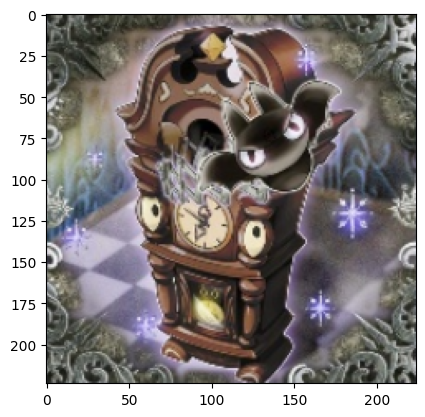

In [ ]:
prefix = "datasets/card_images_small/"

for id in tqdm.tqdm(ids):
    metadata = mysql.get_metadata(id)
    img_path = prefix + str(id) + ".jpg"
    if not os.path.exists(img_path):
        url = f"https://images.ygoprodeck.com/images/cards_small/{id}.jpg"
        print(f"FileNotFound: {id}.jpg")
        try:
            urllib.request.urlretrieve(url, img_path)
        except Exception as e:
            raise e
    img = cv2.imread(img_path)[:, :, ::-1]
    is_pendulum = True if "pendulum" in metadata["type"].lower() else False
    
    model_input = teacher_preprocessor(img, is_pendulum)
    model_input = tf.expand_dims(model_input, 0)
    embed = teacher_model(model_input)
    embed = tf.squeeze(embed, 0).numpy().tolist()

    chroma.insert_one(str(id), embed, metadata)


In [6]:
prefix = "datasets/card_images_small/"

id = ids[0]
metadata = mysql.get_metadata(id)
img_path = prefix + str(id) + ".jpg"
if not os.path.exists(img_path):
    url = f"https://images.ygoprodeck.com/images/cards_small/{id}.jpg"
    print(f"FileNotFound: {id}.jpg")
    try:
        urllib.request.urlretrieve(url, img_path)
    except Exception as e:
        raise e
img = cv2.imread(img_path)[:, :, ::-1]
is_pendulum = True if "pendulum" in metadata["type"].lower() else False
if is_pendulum:
    img = img[70:242, 17:250, :]
else:
    img = img[72:275, 32:236, :]

model_input = teacher_preprocessor(img, is_pendulum)
model_input = tf.expand_dims(model_input, 0)
embed = teacher_model(model_input)
embed = tf.squeeze(embed, 0).numpy().tolist()

In [9]:
img.shape

(203, 204, 3)

In [28]:
img2 = cv2.resize(img, (40, 40))
img2 = cv2.resize(img2, (203, 204))
cv2.imwrite("test4.png", img2[:,:,::-1])
model_input2 = teacher_preprocessor(img2, False)
model_input2 = tf.expand_dims(model_input2, 0)
embed2 = teacher_model(model_input2)
embed2 = tf.squeeze(embed2, 0).numpy().tolist()

In [41]:
res = chroma.search_by_embed(embed2, 30)
for r in res[0]:
    print(r["kor_name"])

증폭하는 맬리스
미도레미코드 엘리티아
암석의 파수병
PSY (싸이) 프레임기어 β (베타)
융합무기 무라사메 검
크롤러 덴드라이트
SPYRAL (스파이랄) －지니어스
솔저 드래곤

아즈텍의 석상
미캉코 카구라
광학위장 아머
배틀 스턴 소닉
포차이
밸리언츠의 취－마모나카
단결하는 검투수
아르카나 포스 ⅩⅧ－더 문
마제스펙터 라쿤
사이버 드래곤 헤르츠
밸리언츠의 무사－호죠
무장 해제
Union Activation
네프티스의 희망
대소동
샐러맨그레이트 코요테
마계극단－코믹 릴리프
밸리언츠의 무녀－시노노메
낙인룡 알비온
수호룡 아가페인
곡예의 마술사


In [8]:
res

[[{'archetype': 'Labrynth',
   'atk': 0,
   'attribute': 'DARK',
   'def': 0,
   'desc': '(Quick Effect): You can discard this card; this turn, you can activate 1 Normal Trap Card that was Set this turn, if you control a "Labrynth" monster. If a card(s) is sent from your hand to the GY to activate your Normal Trap Card or your "Labrynth" card or effect, except "Labrynth Cooclock", while this card is in your GY (except during the Damage Step): You can add this card to your hand, or Special Summon it. You can only use each effect of "Labrynth Cooclock" once per turn.',
   'frame_type': 'effect',
   'id': 2511,
   'image_url_small': 'https://images.ygoprodeck.com/images/cards_small/2511.jpg',
   'kor_desc': '이 카드명의 ①②의 효과는 각각 1턴에 1번밖에 사용할 수 없다. ①: 이 카드를 패에서 버리고 발동할 수 있다. 이 턴에, 자신 필드에 "라뷰린스" 몬스터가 존재할 경우, 자신은 일반 함정 카드 1장을 세트한 턴에 발동할 수 있다. 이 효과는 상대 턴에도 발동할 수 있다. ②: 이 카드가 묘지에 존재하는 상태에서, "라뷰린스 쿠클락" 이외의 "라뷰린스" 카드의 효과 또는 일반 함정 카드를 자신이 발동하기 위해, 패의 카드가 묘지로 보내졌을 경우에 발동할 수 있다. 이 카드를 패에 넣거나 특수 소환한다.'

In [14]:
chroma.collection.peek()

{'ids': ['2511',
  '10000',
  '27551',
  '32864',
  '35699',
  '39015',
  '41546',
  '41777',
  '43227',
  '44818'],
 'embeddings': array([[   0.097749,   -0.090018,    0.033263, ...,    0.028155,   -0.020478,     0.08242],
        [   0.057057,   -0.030572,     0.12816, ...,    0.063241,   -0.022466,     0.10857],
        [   0.024285,   -0.045851,    0.028254, ...,    0.081749,   -0.095606,    0.083073],
        ...,
        [   0.068739,    0.019885,     0.11095, ...,    0.091385,   0.0040844,    0.042986],
        [   0.061225,    0.026052,   0.0016402, ...,    0.015939,   -0.080902,     0.03283],
        [    0.01052,   -0.095559,    0.064687, ...,   0.0040132,    -0.12624,     0.13066]]),
 'metadatas': [{'archetype': 'Labrynth',
   'atk': 0,
   'attribute': 'DARK',
   'def': 0,
   'desc': '(Quick Effect): You can discard this card; this turn, you can activate 1 Normal Trap Card that was Set this turn, if you control a "Labrynth" monster. If a card(s) is sent from your hand to the

In [16]:
embed[0]

array([     0.9233,     0.10259,     0.30213,     0.51202,      1.4611,      1.4031,     0.52046,    -0.37931,      -0.178,     -0.8349,   -0.039159,   -0.021433,     0.48814,     0.23683,    -0.33117,   -0.078018,    -0.14237,   -0.056015,      0.5405,    0.044858,     -0.1519,    -0.47126,      2.2833,     0.69764,
           0.65043,    -0.07337,     0.77079,     -0.2691,    -0.55446,    -0.19362,   -0.037125,  -0.0082151,     0.31589,    -0.98676,    -0.31358,     -1.3709,    -0.95244,    -0.23357,    -0.23631,   -0.090625,    -0.15529,  -0.0064098,    -0.62173,    -0.37126,   -0.052458,   -0.066443,     0.60076,    -0.55837,
            0.1399,   -0.027074,    -0.07395,     0.43276,   -0.028084,    -0.11669,    -0.38853,     0.19196,    -0.18046,     0.62454,    -0.55776,     0.63483,   -0.044062,    -0.37195,   -0.058248,     -0.4546,    -0.51578,   -0.079939,    0.084122,    -0.27631,     0.11749,   -0.055771,   -0.079816,   -0.098701,
         -0.066845,   -0.026987,    -0.5762

In [15]:
embed.shape

(10, 1000)

In [63]:
temp = []
for key in vector_dict.keys():
    try:
        collection.add(
            ids=[key],
            embeddings=[vector_dict[key]],
            metadatas=dataset[key]
        )
    except KeyError:
        temp.append(key)